### 1. Import Packages

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set()

### 2. Load Data

In [2]:
furniture = pd.read_csv(r"C:\zubeda\PGA02_Zubu\Machine Learning Models\TimeSeries\Dataset\Super_Store.csv", sep=",", encoding="cp1252")
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


### 3. Data Preparation

**3.1 Dimensions of Dataset**

In [3]:
#Checking structure of the data
furniture.shape

(2121, 21)

**3.2 Statistical Summary**

In [4]:
furniture.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,55726.556341,349.834887,3.785007,0.173923,8.699327
std,2885.740258,32261.888225,503.179145,2.251620,0.181547,136.049246
min,1.000000,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,99301.000000,4416.174000,14.000000,0.700000,1013.127000


**3.3 Checking for missing values**

In [5]:
#summary of the data
furniture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

Checking the stock time stamp

In [6]:
furniture['Order Date'].min(), furniture['Order Date'].max()

('1/1/2017', '9/9/2017')

We remove the columns that we do not need as well as check missing values

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [8]:
furniture.isnull().sum()

Order Date    0
Ship Date     0
Sales         0
dtype: int64

**3.5 Indexing with Date**

Aggregate price by date

In [9]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [10]:
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])
furniture.set_index('Order Date', inplace=True)
furniture.index

DatetimeIndex(['2017-01-01', '2014-01-10', '2015-01-10', '2016-01-10',
               '2014-01-11', '2016-01-11', '2017-01-12', '2014-01-13',
               '2015-01-13', '2017-01-13',
               ...
               '2014-09-07', '2015-09-07', '2017-09-07', '2014-09-08',
               '2015-09-08', '2016-09-08', '2017-09-08', '2014-09-09',
               '2016-09-09', '2017-09-09'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [11]:
furniture.head()

,Sales
Order Date,
2017-01-01,975.490
2014-01-10,51.940
2015-01-10,1018.104
2016-01-10,104.770
2014-01-11,9.940


### 4. Time Series Analysis

**4.1 Visualizing Data**

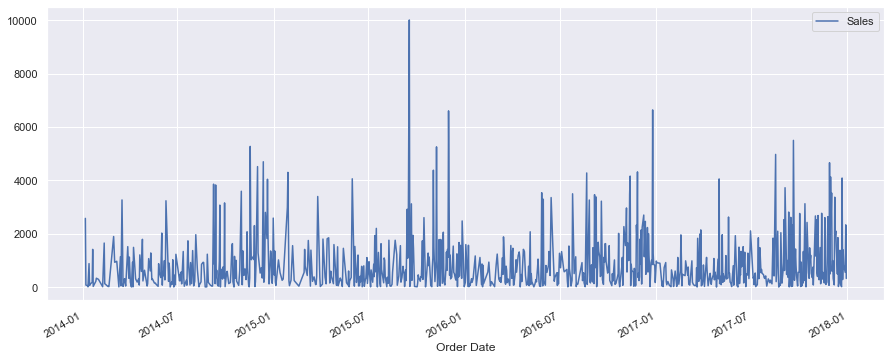

In [13]:
furniture.plot(figsize=(15, 6))
plt.show()

**4.2 Sampling**

In [14]:
y = furniture['Sales'].resample('MS').mean()  #Month Start Resampling
y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049187
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412013
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

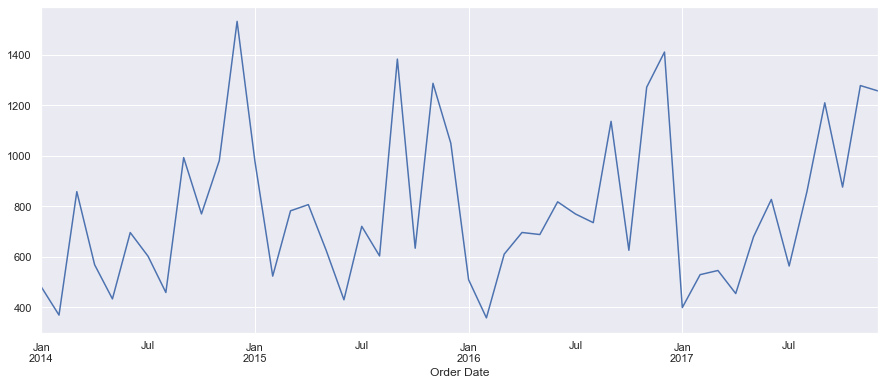

In [15]:
y.plot(figsize=(15, 6))
plt.show()

**4.3 Checking Stationarity**

In [17]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' %(key, value))

ADF Statistic: -5.191070
p-value: 0.000009
Critical Values: 
	1%: -3.621
	5%: -2.944
	10%: -2.610


**4.4 Decomposing**

Decomposing the time series into 3 distinct components

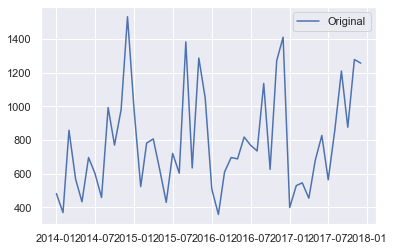

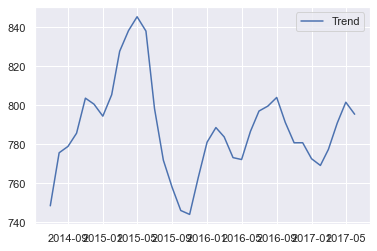

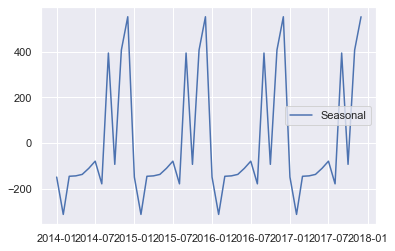

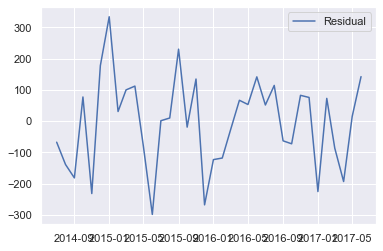

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

plt.plot(y, label='Original')
plt.legend(loc='best')

trend = decomposition.trend
plt.show()
plt.plot(trend, label='Trend')
plt.legend(loc='best')

seasonal = decomposition.seasonal
plt.show()
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

residual = decomposition.resid
plt.show()
plt.plot(residual, label='Residual')
plt.legend(loc='best')

### 5. Time Series Forecasting using ARIMA

In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#The m parameter influences the p, d, and q parameters. For example, an m of 12 for monthly data
#suggests a yearly seasonal cycle.
print('Examples for parameter combination for Seasonal ARIMA....')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples for parameter combination for Seasonal ARIMA....
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
